<a href="https://colab.research.google.com/github/Pranjalya/similar_image_retrieval/blob/master/Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Autoencoders

## Problem Statement

You are provided with a dataset of ~5k 512x512 images, your program should accept an
512x512 input image and return N images from the provided dataset similar to the input image.
To solve this problem, building an AutoEncoder model is recommended.  

__Link to the dataset__ : https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view

## Get Data

In [7]:
!gdown https://drive.google.com/uc?id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
!unzip -qq dataset.zip -d data
!rm -rf dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
To: /content/dataset.zip
243MB [00:01, 129MB/s]


## Load Data

In [1]:
# Importing relevant libraries
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, Activation, Flatten, ReLU, Dense, Reshape
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import pickle

Downsampling images from 512 x 512 to 256 x 256 because of lack of resources.

In [2]:
def get_features(pathdir):
    '''
    Get image features
    Args : 
        pathdir -> Path to directory of images
    '''
    main = []
    for path in os.listdir(pathdir):
        img = image.load_img(pathdir+path, target_size=(256, 256))
        img = image.img_to_array(img)
        img_arr = np.expand_dims(img, axis=-1)
        main.append(img_arr)
    return main

In [3]:
img_data = get_features('data/dataset/')
val_split = 0.2
train_ds, val_ds = img_data[int(val_split*len(img_data)):], img_data[:int(val_split*len(img_data))]
print("There are {} training images and {} images for validation".format(len(train_ds), len(val_ds)))

There are 3791 training images and 947 images for validation


## Create Model

I choose an autoencoder model as we want to get the most similar images, which can be found by generating latent vectors of the images, and then finding the minimum distance between them.


The architecture of my model is : 

__Encoder__

*Input Images -> 2D Convolution (activated with ReLU) -> BatchNormalization -> 2D Convolution (activated with ReLU) -> BatchNormalization -> Flatten -> Dense*

We get the latent features as the intermediate result for this encoder model.
  


__Decoder__

As input to the decoder model, we feed the output of the encoder model.


*Dense -> 2D Convolution Transpose (activated with ReLU) -> BatchNormalization -> 2D Convolution Transpose (activated with ReLU) -> BatchNormalization -> 2D Convolution Transpose (activated with Sigmoid)*

I chose 2D Convolution transpose because it Upsamples the features while performing convolutions to the image.

As the output we get the reconstructed image of original input shape.

In [15]:
def create_autoencoder_model(height, width, channels, latent_image_size=32):
    '''
    Function to build the model
    Args : 
        height -> Height of image (int)
        width -> Width of image (int)
        channels -> 3 (RGB) or 4 (RGBA) or 1 (Grayscale)
        latent_image_size -> The latent image size of encoder result (int)
    Returns :
        Autoencoder Tensorflow Keras model
    '''
    
    input_shape = (height, width, channels)

    ## Building Encoder Model

    # Feed the input to the model
    inputs = Input(shape=input_shape)

    # Feeding to Convolutional network and applying Batch Normalization (et al. Ioffe and Szegedy, 2015)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)     

    # Generating the latent vectors after flattening
    enc_size = K.int_shape(x)
    x = Flatten()(x)
    encoder = Dense(latent_image_size, name='encoder')(x)


    ## Building Decoder Model

    # Feed the output of the Encoder to the Decoder model
    x = Dense(np.prod(enc_size[1:]))(encoder)
    x = Reshape((enc_size[1], enc_size[2], enc_size[3]))(x)

    # Feeding to Convolutional network and applying Batch Normalization 
    # in reverse order as it is decoder. Conv2DTranspose applies Convolutional network
    # while Upsampling simultaneously
    x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)

    # Feeding it to another Conv2DTranspose to recover original Input shape
    x = Conv2DTranspose(filters=channels, kernel_size=(3, 3), padding='same')(x)
    decoder = Activation('sigmoid', name='decoder')(x)

    # Constructing the Autoencoder Model
    autoencoder = Model(inputs, decoder, name='autoencoder')

    return autoencoder

In [16]:
def train_model(train, val, epochs=18, lr=1e-3, batch_size=64):
    '''
    Function to train the Autoencoder model
    Args : 
        train : Training Data (tf.Tensor)
        val : Validation Data (tf.tensor)
        epochs : Number of epochs (int)
        lr : Learning Rate (float)
        batch_size : Batch Size (int)
    '''

    print("Creating model...")
    model = create_autoencoder_model(256, 256, 3)
    model.compile(optimizer=Adam(lr=lr), loss="mse")

    print("Autoencoder model structure")
    print(model.summary())

    # Train the model
    history = model.fit(
        train, train,
        validation_data=(val, val),
        epochs=epochs,
        batch_size=batch_size)

    # Plot the curves
    plt.figure()
    plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig("accerr.png")

    # Saving the model in HDF5 format
    model.save('autoencoder.h5', save_format="h5")

Converting the list of images to Numpy array and normalizing them.

In [6]:
train_ds, val_ds = np.array(train_ds), np.array(val_ds)
train_ds, val_ds = train_ds.astype('float32') / 255.0, val_ds.astype('float32') / 255.0
train_ds, val_ds = train_ds.squeeze(), val_ds.squeeze()

print("Shape of train_ds : {}, val_ds : {}".format(train_ds.shape, val_ds.shape))

Shape of train_ds : (3791, 256, 256, 3), val_ds : (947, 256, 256, 3)


Creating model...
Autoencoder model structure
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_nor

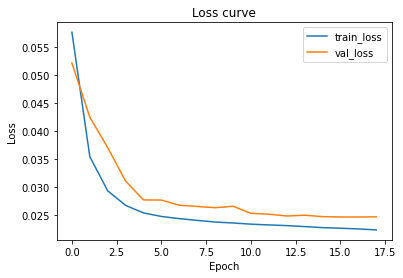

In [17]:
train_model(train_ds, val_ds)

As we can see, our model has generalised quite well.

## Get Latent Features of the Images

Now we get the latent features of the images in form of vectors and store it for efficient retrieval later.

In [18]:
def generate_features(train):
    '''
    Function to create feature vectors for indexing
    Args :
        train : Training images
    '''
    
    print("Loading model...")
    model = load_model("autoencoder.h5")

    # Creating the Encoder model of the Autoencoder
    encoder = Model(inputs=model.input, outputs=model.get_layer("encoder").output)

    # Generating the respective feature of images in latent vector spaces
    print("Creating the feature vectors...")
    features = encoder.predict(train)

    # Hashing the indexes to their respective latent features
    indices = list(range(0, train.shape[0]))
    data = {"indices": indices, "features": features}

    try:
        f = open("latentvectors.pkl", "wb")
        f.write(pickle.dumps(data))
        f.close()
        print("Featurs and images indexed succesfully")
    except Exception as e:
        print("Error : {}".format(e))

In [19]:
generate_features(train_ds)

Loading model...
Creating the feature vectors...
Featurs and images indexed succesfully


Let's check the latent vector features stored in *latentvectors.pkl*

In [20]:
index = pickle.loads(open("/content/latentvectors.pkl", "rb").read())
print(index['indices'][0], " : ", index['features'][0])

0  :  [-44.80856    10.1521845 -18.901333   20.483673   -3.3931253  -1.00258
 -37.466644    5.1652756  14.221103   -8.781261  -31.486507   -5.4421425
  -7.612095   28.045479   12.36742     9.946872   38.974125  -16.549313
  -0.9181584  51.942772   -8.903906  -32.891853    3.1982574 -52.195213
  34.584347  -23.017427   33.693977  -31.107891  -41.92849     3.3972344
  -8.136546    9.496451 ]


Therefore, we have an array of latent features for each of the image.

## Get Nearest Neighbors

Now we find the most similar images based on their latent features.

So, what we're going to do is get the Euclidean distance of the image to be searched and other images. The images with least Euclidean distance will be the most similar images.

This is the formula for computing Euclidean distance.

![Euclidean Distance](https://i.stack.imgur.com/RtnTY.jpg)

In [21]:
# This can be written in Pythonic format as 
def euclidean_distance(source, destination):
    '''
    Function to compute the Euclidean Distance
    Args : 
        source -> Vector
        destination -> Vector
    Returns :
        Euclidean distance -> float
    '''
    return np.linalg.norm(source - destination)

In [22]:
def get_most_similar_images(search, indices, nearest):
    '''
    Function to find the points with least Euclidean Distance
    Args : 
        search -> Source vector
        indices -> Destination vectors
        N -> Number of results to return
    '''
    result = []
    for i in range(len(indices['indices'])):
        result.append((euclidean_distance(search, indices['features'][i]), i))
    
    # Each value in result is in form of (distance, index)    
    return sorted(result)[:nearest]

In [40]:
%matplotlib inline

def get_similar_images(test_sample, train_ds, val_ds, N):
        '''
        Function to get N images similar to the current image
        Args :
            test_sample -> Indices of images to search the similar images for
            train_ds -> Array containing original trained images
            val_ds -> Array containing untrained images
            N -> Number of images to search for (N)
        '''
        # Load model
        model = load_model('autoencoder.h5')
        indices = pickle.loads(open('latentvectors.pkl', 'rb').read())

        # Get the encoder part of the autoencoder
        encoder = Model(inputs=model.input, outputs=model.get_layer('encoder').output)

        # Get the latent features of the sample
        sample_features = encoder.predict(val_ds)

        # Iterate over the required indices
        for i in test_sample:
            images = []

            # Get the indices of most similar N images
            search_results = get_most_similar_images(sample_features[i], indices, nearest=N)

            for dist, ind in search_results:
                img = (train_ds[ind]*255).astype('uint8')
                images.append(np.dstack([img]))
            
            # Displaying image to search
            print("Searching for this image : ")
            search_img = (val_ds[i]*255).astype("uint8")
            plt.imshow(search_img)
            plt.show()

            # Displaying resultant images
            print("Images most similar to the above image are : ")
            fig = plt.figure(figsize=(10, 16))
            for j in range(len(images)):
                fig.add_subplot(N//3+1, 3, j+1)
                plt.imshow(images[j])
            plt.show()

Let's test our model and algorithm.

Searching for this image : 


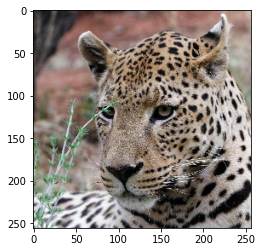

Images most similar to the above image are : 


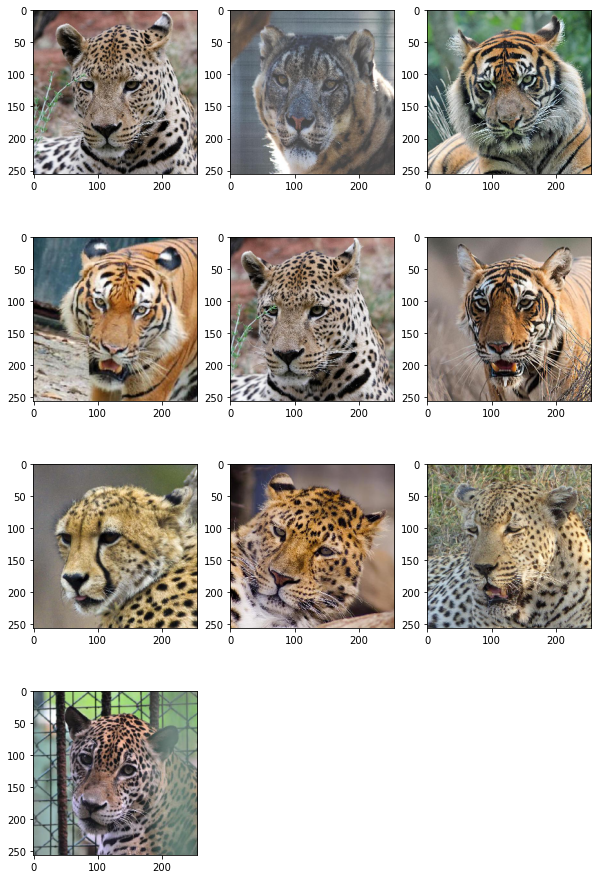

Searching for this image : 


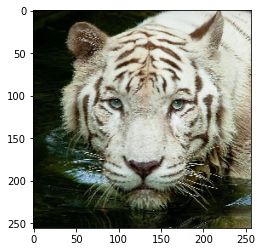

Images most similar to the above image are : 


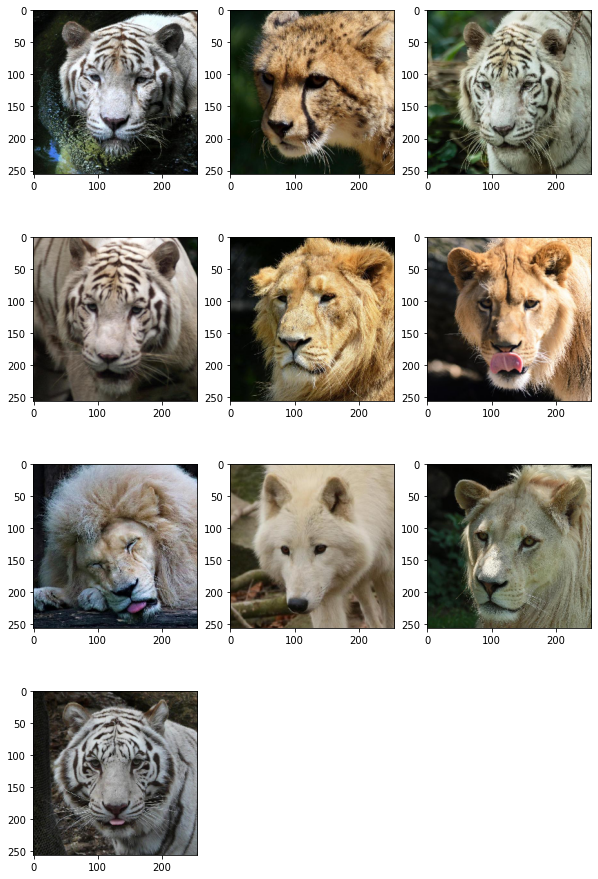

In [41]:
# Let's choose random indices from validation set to get their similar images
get_similar_images([16, 54], train_ds, val_ds, 10)

## Clustering Approach

Now let's try to cluster the images based on their latent vectors.

Here what we are doing is creating clusters of the latent vectors and then based on the cluster which an image belongs to, we sample other images belonging to the same cluster.

In [64]:
from sklearn.cluster import MiniBatchKMeans

def fit_and_predict_cluster(sample, val_ds, train_ds, N):
    '''
    Function to cluster latent vector spaces
    Args :
        indices -> Indices to find similar images for
        val_ds -> Validation set
        train_ds -> Training set
        N -> Number of predictions
    '''

    # Load model
    model = load_model('autoencoder.h5')
    indices = pickle.loads(open('latentvectors.pkl', 'rb').read())

    # Get the encoder part of the autoencoder
    encoder = Model(inputs=model.input, outputs=model.get_layer('encoder').output)

    # Fitting the latent features to MiniBatch KMeans cluster
    kmeans = MiniBatchKMeans(n_clusters=15, batch_size=64)
    kmeans.fit(indices['features'])

    sample_features = encoder.predict(val_ds)

    # Get the cluster ids for training and validation set
    predict_val = kmeans.predict(sample_features)
    predict_train = kmeans.predict(indices['features'])

    for i in sample:
        # Displaying image to search
        print("Searching for this image : ")
        search_img = (val_ds[i]*255).astype("uint8")
        plt.imshow(search_img)
        plt.show()

        # Get the cluster number
        cluster_no = predict_val[i]

        images = []

        for j in range(len(predict_train)):
            if predict_train[j]==cluster_no:
                images.append((train_ds[j]*255).astype("uint8"))
            if len(images)>=N:
                break

        # Displaying resultant images
        print("Images most similar to the above image are : ")
        fig = plt.figure(figsize=(10, 16))
        for j in range(len(images)):
            fig.add_subplot(N//3+1, 3, j+1)
            plt.imshow(images[j])
        plt.show()

Searching for this image : 


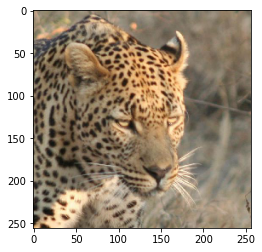

Images most similar to the above image are : 


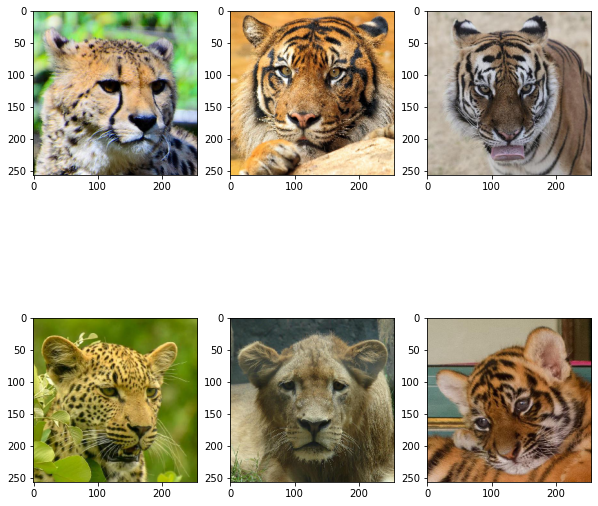

Searching for this image : 


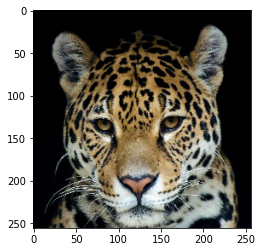

Images most similar to the above image are : 


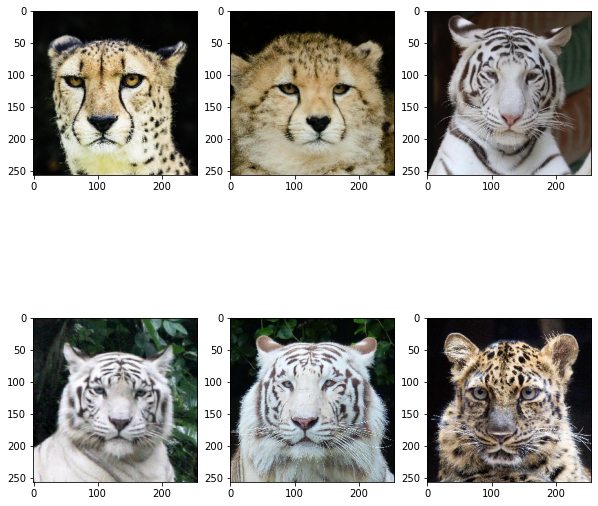

In [65]:
fit_and_predict_cluster([25, 42], val_ds, train_ds, 6)

## Store weights in Google Drive

In [31]:
!cp accerr.png autoencoder.h5 latentvectors.pkl /content/drive/My\ Drive/AI

Weights succesfully stored in Drive.